In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

Let's load the dataset and extract just the comments, rather than using the entire dataset..

In [2]:
data_frame = pd.read_csv("../datasets/reddit_sentiment.csv")
data_frame.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


This dataset is far better as it is simple and concise.

In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


There are about 37000 Tuples in this.. Let's drop some empty values:

In [4]:
data_frame = data_frame.dropna()

In [5]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37149 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37149 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 870.7+ KB


Let's split the test and train dataset right away to keep it seperated from training at all times.

In [6]:
X = data_frame["clean_comment"]
y = data_frame["category"]

Let's initialize and test Roberta:

In [7]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Define your model and tokenizer
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path).to("cuda")  # Move model to GPU


predicted_sentiments = []
scores = []

batch_size = 32
max_length = 128  

num_batches = len(X) // batch_size + (1 if len(X) % batch_size != 0 else 0)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if i < num_batches - 1 else len(X)
    batch_comments = X[start_idx:end_idx]

  
    inputs = tokenizer(list(batch_comments), return_tensors="pt", padding=True, truncation=True, max_length=max_length).to("cuda")  # Move inputs to GPU
    
   
    with torch.no_grad():
        outputs = model(**inputs)
    
   
    logits = outputs.logits
    softmax_scores = torch.nn.functional.softmax(logits, dim=1)
    preds = torch.argmax(logits, dim=1)
    
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    batch_predicted = [pred.item() for pred in preds]
    batch_scores = [score[pred.item()].item() for score, pred in zip(softmax_scores, preds)]
    
    predicted_sentiments.extend(batch_predicted)
    scores.extend(batch_scores)




c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's look at the model metrics now:

In [8]:
y_pred = predicted_sentiments


In [9]:
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] - 1
    

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))


              precision    recall  f1-score   support

          -1       0.41      0.72      0.52      8277
           0       0.52      0.72      0.61     13042
           1       0.82      0.24      0.37     15830

    accuracy                           0.51     37149
   macro avg       0.58      0.56      0.50     37149
weighted avg       0.62      0.51      0.49     37149



In [11]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y, y_pred)


array([[5970, 2136,  171],
       [3015, 9376,  651],
       [5622, 6432, 3776]], dtype=int64)

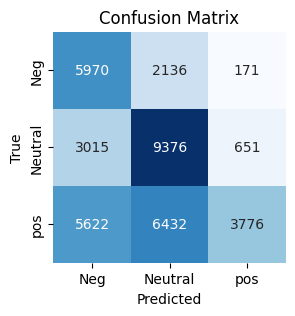

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Create a figure and axis for the plot
    plt.figure(figsize=(len(classes), len(classes)))
    ax = plt.subplot()

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

    # Set labels and title
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title('Confusion Matrix')

    # Show the plot
    plt.show()


class_names = ['Neg', 'Neutral', 'pos']

plot_confusion_matrix(y, y_pred, class_names)
